In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

Using TensorFlow backend.


In [2]:
### READ DATASET ###
df = pd.read_csv('./avocado.csv',index_col=0)
print(df.shape)
df.head()

(18249, 13)


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
### PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE ###
def plot_seris(county, typ):
    plt.figure(figsize=(9,6))
    reg_train = df[np.logical_and(df['type']==typ, df['year']!=2018)].groupby('region')
    p_train = reg_train.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(0,len(p_train)),p_train.AveragePrice.values)
    
    reg_test = df[np.logical_and(df['type']==typ, df['year']==2018)].groupby('region')
    p_test = reg_test.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(len(p_train),len(p_train)+len(p_test)),p_test.AveragePrice.values)
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

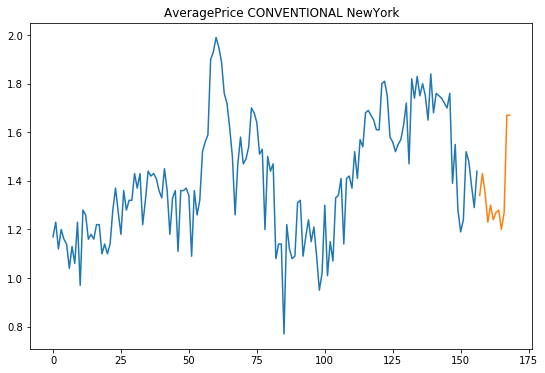

In [4]:
plot_seris('NewYork','conventional')

In [5]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###
sequence_length = 4

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### CREATE TRAIN/TEST PRICE DATA ###
X_train_c, X_train_o = [], []
X_test_c, X_test_o = [], []
X_other_train_c, X_other_train_o = [], []
X_other_test_c, X_other_test_o = [], []

for county in df["region"].unique():
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]!=2018,])], sequence_length, ['AveragePrice']):
        X_train_c.append(sequence) if county != 'Albany' else X_other_train_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]!=2018,])], sequence_length, ['AveragePrice']):
        X_train_o.append(sequence) if county != 'Albany' else X_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        X_test_c.append(sequence) if county != 'Albany' else X_other_test_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        X_test_o.append(sequence) if county != 'Albany' else X_other_test_o.append(sequence)
    
X_train_c, X_train_o = np.asarray(X_train_c), np.asarray(X_train_o)
X_test_c, X_test_o = np.asarray(X_test_c), np.asarray(X_test_o)
X_other_train_c, X_other_train_o = np.asarray(X_other_train_c), np.asarray(X_other_train_o)
X_other_test_c, X_other_test_o = np.asarray(X_other_test_c), np.asarray(X_other_test_o)

In [7]:
### CREATE TRAIN/TEST LABEL ###
y_train_c, y_train_o = [], []
y_test_c, y_test_o = [], []
y_other_train_c, y_other_train_o = [], []
y_other_test_c, y_other_test_o = [], []

for county in df["region"].unique():
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]!=2018,])], sequence_length, ['AveragePrice']):
        y_train_c.append(sequence) if county != 'Albany' else y_other_train_c.append(sequence)
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]!=2018,])], sequence_length, ['AveragePrice']):
        y_train_o.append(sequence) if county != 'Albany' else y_other_train_o.append(sequence)
        
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        y_test_c.append(sequence) if county != 'Albany' else y_other_test_c.append(sequence)
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        y_test_o.append(sequence) if county != 'Albany' else y_other_test_o.append(sequence)

y_train_c, y_train_o = np.asarray(y_train_c), np.asarray(y_train_o)
y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
y_other_train_c, y_other_train_o = np.asarray(y_other_train_c), np.asarray(y_other_train_o)
y_other_test_c, y_other_test_o = np.asarray(y_other_test_c), np.asarray(y_other_test_o)

In [8]:
### CONCATENATE TRAIN/TEST DATA AND LABEL ### 
X = np.concatenate([X_train_c,X_train_o,X_test_c,X_test_o],axis=0)
y = np.concatenate([y_train_c,y_train_o,y_test_c,y_test_o],axis=0)

print(X.shape,y.shape)

(17063, 4, 1) (17063, 1)


In [9]:
### CREATE TRAIN/TEST EXTERNAL FEATURES ###
col = ['Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags']

f_train_c, f_train_o = [], []
f_test_c, f_test_o = [], []
f_other_train_c, f_other_train_o = [], []
f_other_test_c, f_other_test_o = [], []

for county in df["region"].unique():
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]!=2018,])], sequence_length, col):
        f_train_c.append(sequence) if county != 'Albany' else f_other_train_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]!=2018,])], sequence_length, col):
        f_train_o.append(sequence) if county != 'Albany' else f_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, col):
        f_test_c.append(sequence) if county != 'Albany' else f_other_test_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, col):
        f_test_o.append(sequence) if county != 'Albany' else f_other_test_o.append(sequence)
    
f_train_c, f_train_o = np.asarray(f_train_c), np.asarray(f_train_o)
f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)
f_other_train_c, f_other_train_o = np.asarray(f_other_train_c), np.asarray(f_other_train_o)
f_other_test_c, f_other_test_o = np.asarray(f_other_test_c), np.asarray(f_other_test_o)

In [10]:
### CONCATENATE TRAIN/TEST EXTERNAL FEATURES ###
F = np.concatenate([f_train_c,f_train_o,f_test_c,f_test_o],axis=0)

print(F.shape)

(17063, 4, 8)


# FORECASTER + AUTOENCODER

In [12]:
### DEFINE LSTM AUTOENCODER ###
inputs_ae = Input(shape=(sequence_length, 1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            66560     
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 32)             20608     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 1)              33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [13]:
### TRAIN AUTOENCODER ###
sequence_autoencoder.fit(X, X, batch_size=16, epochs=100, verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 13s - loss: 0.1506 - mean_squared_error: 0.1506
Epoch 2/100
 - 11s - loss: 0.0466 - mean_squared_error: 0.0466
Epoch 3/100
 - 12s - loss: 0.0363 - mean_squared_error: 0.0363
Epoch 4/100
 - 11s - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 5/100
 - 12s - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 6/100
 - 11s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 7/100
 - 11s - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 8/100
 - 11s - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 9/100
 - 12s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 10/100
 - 13s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 11/100
 - 11s - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 12/100
 - 12s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 13/100
 - 14s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 14/100
 - 11s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 15/100
 - 11s - loss: 0.0061 - mean_squared_error: 0.0061
E

In [14]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###
encoder = Model(inputs_ae, encoded_ae)
XX = encoder.predict(X)
XXF = np.concatenate([XX, F], axis=2)
XXF.shape

(17063, 4, 136)

In [15]:
### SCALE DATA ###
scaler1 = StandardScaler()
XXF = scaler1.fit_transform(XXF.reshape(-1,128+8)).reshape(-1,sequence_length,128+8)

In [16]:
### SPLIT TRAIN TEST ###
X_train1, X_test1 = XXF[:X_train_c.shape[0]+X_train_o.shape[0]], XXF[X_train_c.shape[0]+X_train_o.shape[0]:]
y_train1, y_test1 = y[:y_train_c.shape[0]+y_train_o.shape[0]], y[y_train_c.shape[0]+y_train_o.shape[0]:]

In [17]:
### DEFINE LSTM FORECASTER ###
inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
lstm1 = LSTM(128, return_sequences=True, dropout=0.3)(inputs1, training=True)
lstm1 = LSTM(32, return_sequences=False, dropout=0.3)(lstm1, training=True)
dense1 = Dense(50)(lstm1)
out1 = Dense(1)(dense1)

model1 = Model(inputs1, out1)

model1.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [18]:
### FIT FORECASTER ###
history = model1.fit(X_train1, y_train1, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
 - 5s - loss: 0.1389 - mean_squared_error: 0.1389
Epoch 2/30
 - 3s - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 3/30
 - 3s - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 4/30
 - 3s - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 5/30
 - 3s - loss: 0.0309 - mean_squared_error: 0.0309
Epoch 6/30
 - 3s - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 7/30
 - 3s - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 8/30
 - 3s - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 9/30
 - 3s - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 10/30
 - 3s - loss: 0.0295 - mean_squared_error: 0.0295
Epoch 11/30
 - 3s - loss: 0.0290 - mean_squared_error: 0.0290
Epoch 12/30
 - 3s - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 13/30
 - 3s - loss: 0.0286 - mean_squared_error: 0.0286
Epoch 14/30
 - 3s - loss: 0.0284 - mean_squared_error: 0.0284
Epoch 15/30
 - 3s - loss: 0.0285 - mean_squared_error: 0.0285
Epoch 16/30
 - 3s - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 17/30
 - 3s

In [19]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop1(r):
    enc = K.function([encoder.layers[0].input, K.learning_phase()], [encoder.layers[-1].output])
    NN = K.function([model1.layers[0].input, K.learning_phase()], [model1.layers[-1].output])
    
    enc_pred = np.vstack(enc([X[X_train_c.shape[0]+X_train_o.shape[0]:],r]))
    enc_pred = np.concatenate([enc_pred, F[X_train_c.shape[0]+X_train_o.shape[0]:]], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,128+8)).reshape(-1,sequence_length,128+8)
    NN_pred = NN([trans_pred,r])
    
    return np.vstack(NN_pred)

In [20]:
### COMPUTE STOCHASTIC DROPOUT ###
scores1 = []
for i in tqdm.tqdm(range(0,100)):
    scores1.append(mean_absolute_error(stoc_drop1(0.5), y_test1))

print(np.mean(scores1), np.std(scores1))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.43it/s]


0.11719414456385488 0.0012894588622894571


# SIMPLE FORECASTER

In [21]:
### CONCATENATE REGRESSORS ###
XF = np.concatenate([X, F], axis=2)
print(XF.shape)

(17063, 4, 9)


In [22]:
### SCALE DATA ###
scaler2 = StandardScaler()
XF = scaler2.fit_transform(XF.reshape(-1,1+8)).reshape(-1,sequence_length,1+8)

In [23]:
### SPLIT TRAIN TEST ###
X_train2, X_test2 = XF[:X_train_c.shape[0]+X_train_o.shape[0]], XF[X_train_c.shape[0]+X_train_o.shape[0]:]
y_train2, y_test2 = y[:y_train_c.shape[0]+y_train_o.shape[0]], y[y_train_c.shape[0]+y_train_o.shape[0]:]

In [24]:
### DEFINE LSTM FORECASTER ###
inputs2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
lstm2 = LSTM(128, return_sequences=True, dropout=0.3)(inputs2, training=True)
lstm2 = LSTM(32, return_sequences=False, dropout=0.3)(lstm2, training=True)
dense2 = Dense(50)(lstm2)
out2 = Dense(1)(dense2)

model2 = Model(inputs2, out2)

model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [25]:
### FIT FORECASTER ###
history = model2.fit(X_train2, y_train2, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
 - 5s - loss: 0.2877 - mean_squared_error: 0.2877
Epoch 2/30
 - 3s - loss: 0.0548 - mean_squared_error: 0.0548
Epoch 3/30
 - 3s - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 4/30
 - 3s - loss: 0.0448 - mean_squared_error: 0.0448
Epoch 5/30
 - 3s - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 6/30
 - 3s - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 7/30
 - 3s - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 8/30
 - 3s - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 9/30
 - 3s - loss: 0.0356 - mean_squared_error: 0.0356
Epoch 10/30
 - 3s - loss: 0.0363 - mean_squared_error: 0.0363
Epoch 11/30
 - 3s - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 12/30
 - 3s - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 13/30
 - 3s - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 14/30
 - 3s - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 15/30
 - 3s - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 16/30
 - 3s - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 17/30
 - 3s

In [26]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop2(r):
    NN = K.function([model2.layers[0].input, K.learning_phase()], [model2.layers[-1].output])
    
    NN_pred = NN([XF[X_train_c.shape[0]+X_train_o.shape[0]:],r])
    
    return np.vstack(NN_pred)

In [27]:
### COMPUTE STOCHASTIC DROPOUT ###
scores2 = []
for i in tqdm.tqdm(range(0,100)):
    scores2.append(mean_absolute_error(stoc_drop2(0.5), y_test2))

print(np.mean(scores2), np.std(scores2))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.74it/s]


0.12497125592161462 0.001685169666778367


# COMPARE RESULTS

In [28]:
### FUNCTION TO GET TEST DATA FOR COUNTY ###
def test_county(county):
    
    test_X_c, test_X_o = [], []
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        test_X_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        test_X_o.append(sequence)    
    test_X_c, test_X_o = np.asarray(test_X_c), np.asarray(test_X_o)
    
    test_y_c, test_y_o = [], []
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        test_y_c.append(sequence)
    for sequence in gen_labels(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, ['AveragePrice']):
        test_y_o.append(sequence)
    test_y_c, test_y_o = np.asarray(test_y_c), np.asarray(test_y_o)
    
    test_F_c, test_F_o = [], []
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="conventional", df["year"]==2018,])], sequence_length, col):
        test_F_c.append(sequence)
    for sequence in gen_sequence(df[np.logical_and.reduce([df["region"]==county,df["type"]=="organic", df["year"]==2018,])], sequence_length, col):
        test_F_o.append(sequence)
    test_F_c, test_F_o = np.asarray(test_F_c), np.asarray(test_F_o)
    
    X = np.concatenate([test_X_c,test_X_o],axis=0)
    y = np.concatenate([test_y_c,test_y_o],axis=0)
    F = np.concatenate([test_F_c,test_F_o],axis=0)
    
    return X, y, F

In [29]:
### FUNCTION FOR STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
def test_stoc_drop1(county, r):
    X, y, F = test_county(county)
    
    enc = K.function([encoder.layers[0].input, K.learning_phase()], [encoder.layers[-1].output])
    NN = K.function([model1.layers[0].input, K.learning_phase()], [model1.layers[-1].output])
    
    enc_pred = np.vstack(enc([X, r]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,128+8)).reshape(-1,sequence_length,128+8)
    NN_pred = NN([trans_pred, r])
    
    return np.vstack(NN_pred), y


def test_stoc_drop2(county, r):
    X, y, F = test_county(county)
    
    NN = K.function([model2.layers[0].input, K.learning_phase()], [model2.layers[-1].output])
    
    trans_pred = scaler2.transform(np.concatenate([X,F], axis=2).reshape(-1,1+8)).reshape(-1,sequence_length,1+8)
    NN_pred = NN([trans_pred, r])
    
    return np.vstack(NN_pred), y

In [30]:
pred1_test, y1_test = test_stoc_drop1('TotalUS', 0.5)

In [31]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae1_test = []
for i in tqdm.tqdm(range(0,100)):
    mae1_test.append(mean_absolute_error(test_stoc_drop1('TotalUS', 0.5)[0], y1_test))

print(np.mean(mae1_test), np.std(mae1_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.02s/it]


0.07318233214020728 0.009157243492813858


In [32]:
pred2_test, y2_test = test_stoc_drop2('TotalUS', 0.5)

In [33]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae2_test = []
for i in tqdm.tqdm(range(0,100)):
    mae2_test.append(mean_absolute_error(test_stoc_drop2('TotalUS', 0.5)[0], y2_test))

print(np.mean(mae2_test), np.std(mae2_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.21it/s]


0.09000493792295457 0.016490624212672684


Text(0.5,1,'TotalUS')

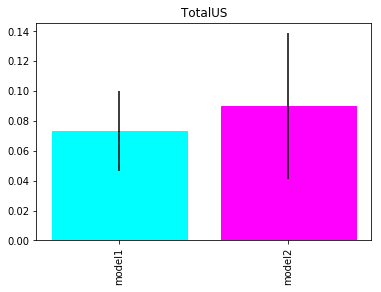

In [34]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###
bar = plt.bar([0,1],[np.mean(mae1_test), np.mean(mae2_test)], yerr=[2.95*np.std(mae1_test), 2.95*np.std(mae2_test)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('TotalUS')

# UNSEEN DATA PREDICTION

In [35]:
### FUNCTION FOR STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
def test_other_drop1(r, typ):
    
    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
            
    enc = K.function([encoder.layers[0].input, K.learning_phase()], [encoder.layers[-1].output])
    NN = K.function([model1.layers[0].input, K.learning_phase()], [model1.layers[-1].output])
    
    enc_pred = np.vstack(enc([X, r]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,128+8)).reshape(-1,sequence_length,128+8)
    NN_pred = NN([trans_pred, r])
    
    return np.vstack(NN_pred), y


def test_other_drop2(r, typ):

    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
    
    NN = K.function([model2.layers[0].input, K.learning_phase()], [model2.layers[-1].output])
    
    trans_pred = scaler2.transform(np.concatenate([X,F], axis=2).reshape(-1,1+8)).reshape(-1,sequence_length,1+8)
    NN_pred = NN([trans_pred, r])
    
    return np.vstack(NN_pred), y

In [36]:
### COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
mae1_other, p1_other = [], []
for i in tqdm.tqdm(range(0,100)):
    pred1_other, true1_other = test_other_drop1(0.5, 'organic')
    mae1_other.append(mean_absolute_error(pred1_other, true1_other))
    p1_other.append(pred1_other)

print(np.mean(mae1_other), np.std(mae1_other))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.02it/s]


0.091101776751228 0.003437280589255799


In [37]:
### COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
mae2_other, p2_other = [], []
for i in tqdm.tqdm(range(0,100)):
    pred2_other, true2_other = test_other_drop2(0.5, 'organic')
    mae2_other.append(mean_absolute_error(pred2_other, true2_other))
    p2_other.append(pred2_other)

print(np.mean(mae2_other), np.std(mae2_other))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.46it/s]


0.09643079307005273 0.0035456840369173384


Text(0.5,1,'ORGANIC Albany')

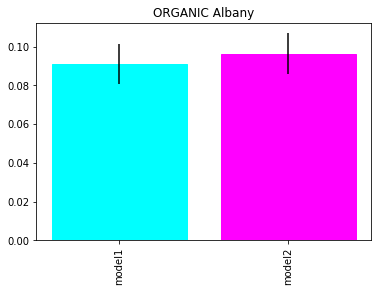

In [38]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###
bar = plt.bar([0,1],[np.mean(mae1_other), np.mean(mae2_other)], yerr=[2.95*np.std(mae1_other), 2.95*np.std(mae2_other)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('ORGANIC Albany')

Text(0.5,1,'AveragePrice CONVENTIONAL Albany - Model1')

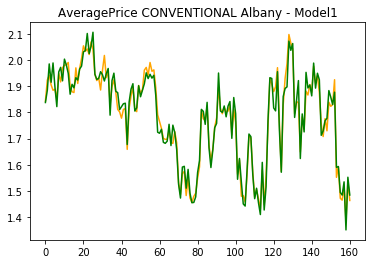

In [39]:
plt.plot(np.mean(np.hstack(p1_other).T,axis=0),color='orange')
plt.plot(pred1_other,color='green')
plt.title('AveragePrice CONVENTIONAL Albany - Model1')

Text(0.5,1,'AveragePrice CONVENTIONAL Albany - Model2')

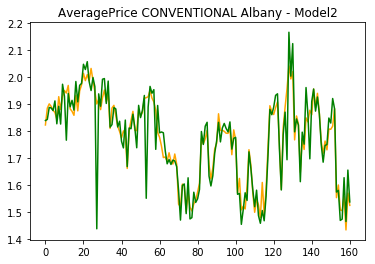

In [40]:
plt.plot(np.mean(np.hstack(p2_other).T,axis=0),color='orange')
plt.plot(pred2_other,color='green')
plt.title('AveragePrice CONVENTIONAL Albany - Model2')